In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random
import os
import json

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
import pytorch3d.transforms
import PIL
from scipy import ndimage
from tqdm.autonotebook import tqdm
import pandas as pd
import shutil

import postprocess_dataset
from utils import utils
from utils import visualization_tools
from utils.eval_utils import eval_metrics
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist, brute_force_estimate_dist_cam_pos, rgba_obj_in_frame
#from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [4]:
# reverse engineered from 
# https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/renderer/cameras.html#camera_position_from_spherical_angles
def cart_to_spherical(cart_coords):
    x = cart_coords[0]
    y = cart_coords[1]
    z = cart_coords[2]
    
    dist = np.sqrt(x**2 + y**2 + z**2)
    elev = np.arcsin(y)/dist
    #azim = np.arctan(x/z)
    azim = np.arctan(x/z) + np.pi
    return dist, elev, azim
    
def spherical_to_cart(dist, elev, azim):
    x = dist * np.cos(elev) * np.sin(azim)
    y = dist * np.sin(elev)
    z = dist * np.cos(elev) * np.cos(azim)
    print(x,y,z)

In [5]:
# assumes cam_pos is a vector of numbers
def find_best_fitting_cam_pos(mesh, cam_pos, num_dists, device, batch_size=8):
    # normalizing
    with torch.no_grad():
        eyes = [cam_pos*i for i in np.geomspace(0.005, 2, num_dists)]
        R, T = look_at_view_transform(eye=eyes)
        meshes = mesh.extend(num_dists)
        renders = utils.render_mesh(meshes, R, T, device)
        
        rendered_image_fits = []
        for i in range(renders.shape[0]):
            rendered_image_fits.append(rgba_obj_in_frame(renders[i].cpu().numpy()))

        # choose closest cam_pos, whose rendered image will fit completely in the frame
        i = 0
        while not rendered_image_fits[i]:
            i+=1

        best_cam_pos = eyes[i]
        
    return best_cam_pos

def get_iou(mask1, mask2):
    intersect = mask1 * mask2 # Logical AND
    union = mask1 + mask2 # Logical OR
    IOU = intersect.sum()/float(union.sum())
    return IOU

In [6]:
def process_pix3d_image(curr_info_dict, visualize=False, inplane=True, use_spherical=True):
    #pprint.pprint(curr_info_dict)
    img_path = os.path.join(PIX3D_PATH, curr_info_dict["img"])
    mesh_path = os.path.join(PIX3D_PATH, curr_info_dict["model"])
    mask_path = os.path.join(PIX3D_PATH, curr_info_dict["mask"])
    cam_pos = curr_info_dict["cam_position"]
    theta = curr_info_dict["inplane_rotation"]
    img = Image.open(img_path)
    mesh = utils.load_untextured_mesh(mesh_path, device)

    up_axis = [0,1,0] 
    if inplane:
        theta = curr_info_dict["inplane_rotation"]
        inplane_R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta),0],[0,0,1]])
        up_axis = (inplane_R@np.array([up_axis]).T).T[0]

    # obtaining GT pose in spherical coordinates
    cam_pos = np.array(cam_pos)/np.sqrt(cam_pos[0]**2+cam_pos[1]**2+cam_pos[2]**2)
    dist, elev, azim = cart_to_spherical(cam_pos)
    azim = azim * (180/np.pi) 
    elev = elev * (180/np.pi) 
    R, T = look_at_view_transform(dist,elev,azim, up=[up_axis])
    spherical_based_render = utils.render_mesh(mesh, R, T, device, img_size=img_size)

    # double checking spherical coordinates conversion to see it it matches camera position based pose
    # Note sure why this is necessary
    R, T = look_at_view_transform(eye=[cam_pos], up=[up_axis])
    cam_based_render = utils.render_mesh(mesh, R, T, device, img_size=img_size)
    render_comparision_iou = get_iou(spherical_based_render[0,...,3]>0, cam_based_render[0,...,3]>0)
    flipped=False
    if render_comparision_iou.item() < 0.95:
        azim += 180
        R, T = look_at_view_transform(dist,elev,azim, up=[up_axis])
        spherical_based_render = utils.render_mesh(mesh, R, T, device, img_size=img_size)
        flipped=True
    
    mask = Image.open(mask_path)
    mask_bbox = curr_info_dict["bbox"]
    img_masked_rgba = Image.composite(Image.new("RGBA", curr_info_dict['img_size']), img.convert('RGBA'), PIL.ImageOps.invert(mask))
    img_masked_rgba = img_masked_rgba.crop(mask_bbox)

    objs = ndimage.find_objects(spherical_based_render[0,...,3].detach().cpu().numpy()>0.2)
    # upper left, lower right
    #render_bbox = [objs[0][0].start, objs[0][1].start, objs[0][0].stop, objs[0][1].stop]
    render_bbox = [objs[0][1].start, objs[0][0].start, objs[0][1].stop, objs[0][0].stop]
    render_bbox_width = render_bbox[2] - render_bbox[0]
    render_bbox_height = render_bbox[3] - render_bbox[1]
    img_masked_rgba_resized = img_masked_rgba.resize((render_bbox_width, render_bbox_height))
    processed_img = Image.new("RGBA", (img_size, img_size))
    processed_img.paste(img_masked_rgba_resized, box=render_bbox[:2])

    final_iou = get_iou(spherical_based_render[0, ..., 3].detach().cpu().numpy() > 0, np.array(processed_img)[...,3]>0)
    if visualize:
        plt.imshow(img_masked_rgba)
        plt.show()
        plt.imshow(spherical_based_render[0, ..., :3].detach().cpu().numpy())
        plt.show()
        plt.imshow(processed_img)
        plt.show()
    return processed_img, dist, elev, azim, final_iou

In [35]:
pix3d_class = "bed"

PIX3D_PATH = "/home/svcl-oowl/dataset/pix3d"
PROCESSED_PIX3D_PATH = "data/pix3d_images_processed"
device = torch.device("cuda:0")
img_size = 224
blacklist = ["img/table/0045", "img/table/1749"]
recompute=False

processed_class_output_dir = os.path.join(PROCESSED_PIX3D_PATH, pix3d_class, "rgba")
processed_class_output_dir_rgb = os.path.join(PROCESSED_PIX3D_PATH, pix3d_class, "rgb")
if not os.path.exists(processed_class_output_dir):
    os.makedirs(processed_class_output_dir)
if not os.path.exists(processed_class_output_dir_rgb):
    os.makedirs(processed_class_output_dir_rgb)
pose_dict_path = os.path.join(processed_class_output_dir, "renders_camera_params.pt")
iou_dict_path = os.path.join(processed_class_output_dir, "iou_info.pt")

In [ ]:
with open(os.path.join(PIX3D_PATH, "pix3d.json")) as f:
    pix3d_data_json = json.loads(f.read())
# convert list of dicts into a dict (keyed by image path) of dicts
pix3d_data_dict = { entry["img"].split('.')[0]:entry for entry in pix3d_data_json}

In [ ]:
if os.path.exists(pose_dict_path):
    pose_dict = pickle.load(open(pose_dict_path, "rb"))
else:
    pose_dict = {}
    
if os.path.exists(iou_dict_path):
    iou_dict = pickle.load(open(iou_dict_path, "rb"))
else:
    iou_dict = {}

class_instance_names = [instance_name for instance_name in pix3d_data_dict.keys() if pix3d_class in instance_name]
for instance_name in tqdm(class_instance_names):
    instance_class_id = instance_name.split('/')[-1]
    processed_img_path = os.path.join(processed_class_output_dir, "{}.png".format(instance_class_id))
    if instance_name not in blacklist and (recompute or not os.path.exists(processed_img_path)):
        print(instance_name)
        processed_img, dist, elev, azim, iou = process_pix3d_image(pix3d_data_dict[instance_name], visualize=False)
        iou_dict[instance_class_id] = iou
        pose_dict[instance_class_id] = {"azim": azim, "elev": elev, "dist": dist}
        pickle.dump(iou_dict, open(iou_dict_path, "wb"))
        pickle.dump(pose_dict, open(pose_dict_path, "wb"))
        processed_img.save(processed_img_path)
        

In [ ]:
#pprint.pprint(pickle.load(open(iou_dict_path, "rb")))
#pprint.pprint(pickle.load(open(pose_dict_path, "rb")))

In [36]:
# convert rgba images to rgb
rgba_img_paths = glob.glob(os.path.join(processed_class_output_dir, "*.png"))
for rgba_img_path in tqdm(rgba_img_paths):
    rgb_img_path = rgba_img_path.replace("rgba", "rgb").replace(".png", ".jpg")
    rgba_img = Image.open(rgba_img_path)
    background = Image.new('RGBA', rgba_img.size, (255,255,255))
    rgb_img = Image.alpha_composite(background, rgba_img)
    rgb_img = rgb_img.convert("RGB")
    rgb_img.save(rgb_img_path)

bed: 994 -> 555



bookcase: 361 -> 239



chair: 3839 -> 1527



desk: 700 -> 278



misc: 68 -> 39



sofa: 1947 -> 1852



table: 1868 -> 580



tool: 47 -> 15



wardrobe: 243 -> 240


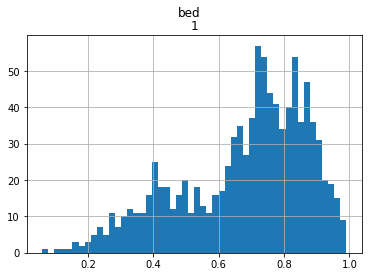

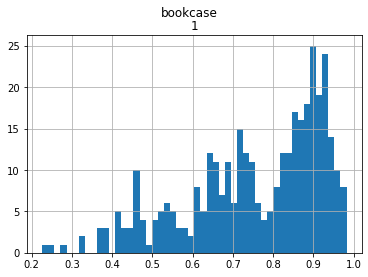

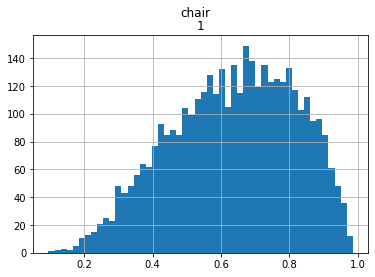

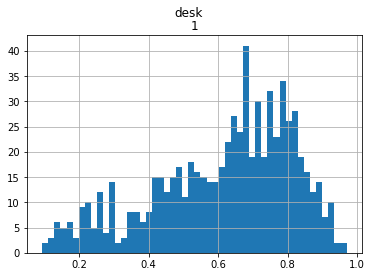

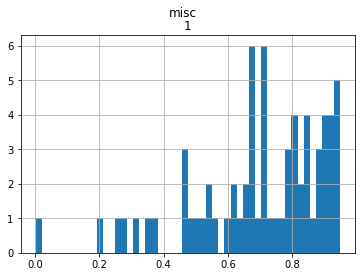

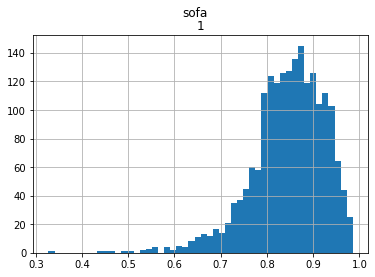

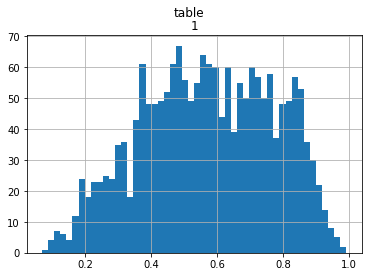

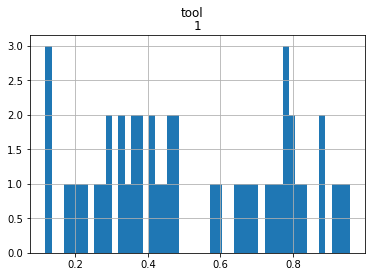

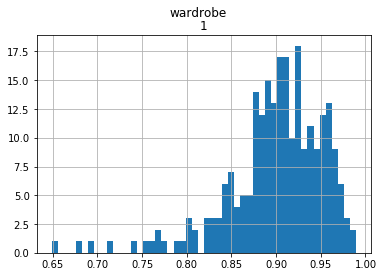

In [83]:
# creating a copy of processed pix3d dataset filtered by high quality iou
iou_thresh = 0.7
PROCESSED_FILTERED_PIX3D_PATH = PROCESSED_PIX3D_PATH + "_filtered"

#pix3d_classes = ["tool"]
pix3d_classes = ["bed",  "bookcase",  "chair",  "desk",  "misc",  "sofa",  "table",  "tool",  "wardrobe"]
for pix3d_class in tqdm(pix3d_classes):
    processed_class_output_dir = os.path.join(PROCESSED_PIX3D_PATH, pix3d_class, "rgba")
    processed_class_output_dir_rgb = os.path.join(PROCESSED_PIX3D_PATH, pix3d_class, "rgb")

    processed_filtered_class_output_dir = os.path.join(PROCESSED_FILTERED_PIX3D_PATH, pix3d_class, "rgba")
    processed_filtered_class_output_dir_rgb = os.path.join(PROCESSED_FILTERED_PIX3D_PATH, pix3d_class, "rgb")
    if not os.path.exists(processed_filtered_class_output_dir):
        os.makedirs(processed_filtered_class_output_dir)
    if not os.path.exists(processed_filtered_class_output_dir_rgb):
        os.makedirs(processed_filtered_class_output_dir_rgb)
    
    processed_class_output_dir = os.path.join(PROCESSED_PIX3D_PATH, pix3d_class, "rgba")
    iou_dict_path = os.path.join(processed_class_output_dir, "iou_info.pt")

    iou_dict = pickle.load(open(iou_dict_path, "rb"))
    iou_df = pd.DataFrame.from_dict(iou_dict.items())
    iou_df_thresh = iou_df[iou_df[1]>iou_thresh]
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    fig.show()
    iou_df.hist(bins=50, ax=axes)
    fig.suptitle(pix3d_class)
    print("{}: {} -> {}".format(pix3d_class, len(iou_df), len(iou_df_thresh)))
    
    high_quality_instances = iou_df_thresh[0].to_list()
    
    original_iou_info = pickle.load(open(os.path.join(processed_class_output_dir, "iou_info.pt"), "rb"))
    filtered_iou_info = {instance:original_iou_info[instance] for instance in original_iou_info if instance in high_quality_instances}
    pickle.dump(filtered_iou_info, open(os.path.join(processed_filtered_class_output_dir, "iou_info.pt"), "wb"))
    
    original_cameras_info = pickle.load(open(os.path.join(processed_class_output_dir, "renders_camera_params.pt"), "rb"))
    filtered_cameras_info = {instance:original_cameras_info[instance] for instance in original_cameras_info if instance in high_quality_instances}
    pickle.dump(filtered_cameras_info, open(os.path.join(processed_filtered_class_output_dir, "renders_camera_params.pt"), "wb"))
    
    for high_quality_instance in tqdm(high_quality_instances):
        original_instance_path = os.path.join(processed_class_output_dir, "{}.png".format(high_quality_instance))
        original_instance_path_rgb = os.path.join(processed_class_output_dir_rgb, "{}.jpg".format(high_quality_instance))
        
        dest_instance_path = os.path.join(processed_filtered_class_output_dir, "{}.png".format(high_quality_instance))
        dest_instance_path_rgb = os.path.join(processed_filtered_class_output_dir_rgb, "{}.jpg".format(high_quality_instance))
        
        #print(original_instance_path, original_instance_path_rgb)
        #print(dest_instance_path, dest_instance_path_rgb)
        shutil.copyfile(original_instance_path, dest_instance_path)
        shutil.copyfile(original_instance_path_rgb, dest_instance_path_rgb)
    

In [82]:
display(pickle.load(open(os.path.join(processed_filtered_class_output_dir, "iou_info.pt"), "rb")))
print(os.path.join(processed_filtered_class_output_dir, "iou_info.pt"))

display(pickle.load(open(os.path.join(processed_filtered_class_output_dir, "renders_camera_params.pt"), "rb")))
print(os.path.join(processed_filtered_class_output_dir, "renders_camera_params.pt"))

{'0002': 0.7783418821312676,
 '0004': 0.8845405815663394,
 '0005': 0.8133922152613742,
 '0008': 0.7997555510287228,
 '0012': 0.9107601184600197,
 '0017': 0.757001647446458,
 '0018': 0.8265794110244148,
 '0024': 0.7506029908345393,
 '0025': 0.7214633016902061,
 '0030': 0.9369817578772802,
 '0031': 0.8027210884353742,
 '0037': 0.955793703951775,
 '0038': 0.8771689497716895,
 '0046': 0.7740481556161783,
 '0047': 0.7761274351522979}

data/pix3d_images_processed_filtered/tool/rgba/iou_info.pt


{'0002': {'azim': 121.24733510377571,
  'elev': 40.656558706747084,
  'dist': 0.9999999999999999},
 '0004': {'azim': 277.56503664771583, 'elev': 28.712301921967587, 'dist': 1.0},
 '0005': {'azim': 190.17924501165572, 'elev': 40.488350493733044, 'dist': 1.0},
 '0008': {'azim': 214.8604676249816, 'elev': 20.591192460271387, 'dist': 1.0},
 '0012': {'azim': 181.23953592340564, 'elev': 4.719748345881564, 'dist': 1.0},
 '0017': {'azim': 168.16830111491862, 'elev': 45.30676158844392, 'dist': 1.0},
 '0018': {'azim': 315.839935370574,
  'elev': 29.32400437730272,
  'dist': 0.9999999999999999},
 '0024': {'azim': 130.78223889480088, 'elev': 38.7972145142091, 'dist': 1.0},
 '0025': {'azim': 447.4185112239083,
  'elev': 29.88876201025528,
  'dist': 0.9999999999999999},
 '0030': {'azim': 133.84298797923364, 'elev': 37.20343929472265, 'dist': 1.0},
 '0031': {'azim': 119.26729710476036, 'elev': 22.29503094584309, 'dist': 1.0},
 '0037': {'azim': 134.16229735597346,
  'elev': 36.27358309219083,
  'dist'

data/pix3d_images_processed_filtered/tool/rgba/renders_camera_params.pt


In [5]:
# correct some issues in the renders_camera_params file: 1) turns everything into floats, 2) subtracts azim by 90
pix3d_img_folder_to_fix = "data/input_images/pix3d_images_processed"
camera_params_paths = [str(path) for path in list(Path(pix3d_img_folder_to_fix).rglob('renders_camera_params.pt'))]
for camera_params_path in camera_params_paths:
    shutil.copyfile(camera_params_path, camera_params_path.replace("renders_camera_params", "original_renders_camera_params"))
    original_camera_params = pickle.load(open(camera_params_path, "rb"))
    fixed_camera_params = {}
    for instance in original_camera_params:
        fixed_camera_params[instance] = {'azim': float(original_camera_params[instance]['azim'])-90, 'dist': float(original_camera_params[instance]['dist']), 'elev': float(original_camera_params[instance]['elev'])}
    
    pickle.dump(fixed_camera_params, open(camera_params_path, "wb"))
    

In [14]:
pprint.pprint(pickle.load(open("data/pix3d_images_processed_filtered/tool/rgba/renders_camera_params-Copy1.pt", "rb")))
#pprint.pprint(pickle.load(open("data/pix3d_images_processed_filtered/tool/rgba/renders_camera_params.pt", "rb")))

{'0002': {'azim': 121.24733510377571,
          'dist': 0.9999999999999999,
          'elev': 40.656558706747084},
 '0004': {'azim': 277.56503664771583, 'dist': 1.0, 'elev': 28.712301921967587},
 '0005': {'azim': 190.17924501165572, 'dist': 1.0, 'elev': 40.488350493733044},
 '0008': {'azim': 214.8604676249816, 'dist': 1.0, 'elev': 20.591192460271387},
 '0012': {'azim': 181.23953592340564, 'dist': 1.0, 'elev': 4.719748345881564},
 '0017': {'azim': 168.16830111491862, 'dist': 1.0, 'elev': 45.30676158844392},
 '0018': {'azim': 315.839935370574,
          'dist': 0.9999999999999999,
          'elev': 29.32400437730272},
 '0024': {'azim': 130.78223889480088, 'dist': 1.0, 'elev': 38.7972145142091},
 '0025': {'azim': 447.4185112239083,
          'dist': 0.9999999999999999,
          'elev': 29.88876201025528},
 '0030': {'azim': 133.84298797923364, 'dist': 1.0, 'elev': 37.20343929472265},
 '0031': {'azim': 119.26729710476036, 'dist': 1.0, 'elev': 22.29503094584309},
 '0037': {'azim': 134.16229